In [ ]:
!git clone https://github.com/AbdElRahmanElGharib/DistYOLO.git
!mv /content/DistYOLO/* /content/
!rm LICENSE README.md
from google.colab.files import upload
upload()
from google.colab.drive import mount
mount('/content/drive/')
!pip install -q keras-cv
!pip install -q kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --unzip -d klemenko/kitti-dataset
!mkdir ./images ./labels
!mv /content/data_object_label_2/training/label_2/* ./labels/
!mv /content/data_object_image_2/training/image_2/* ./images/
!rm -r /content/data_object_image_3/ /content/data_object_calib/ /content/data_object_image_2/ /content/data_object_label_2/ /content/DistYOLO/ /content/sample_data/

Cloning into 'DistYOLO'...
remote: Enumerating objects: 322, done.
remote: Counting objects: 100% (322/322), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 322 (delta 178), reused 270 (delta 135), pack-reused 0
Receiving objects: 100% (322/322), 55.01 KiB | 2.04 MiB/s, done.
Resolving deltas: 100% (178/178), done.


Saving kaggle.json to kaggle.json
Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.0 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/klemenko/kitti-dataset
License(s): other
100% 22.5G/22.5G [04:57<00:00, 110MB/s] 
100% 22.5G/22.5G [04:57<00:00, 81.1MB/s]


In [ ]:
# !git clone https://github.com/dog-qiuqiu/Yolo-FastestV2.git
# !rm -r /content/sample_data/
# !mv /content/Yolo-FastestV2/* /content/
# !rm -r /content/Yolo-FastestV2/
!python pytorch2onnx.py --data data/coco.data --weights modelzoo/coco2017-0.241078ap-model.pth --output yolo-fastestv2.onnx

load param...
/content/model/backbone/shufflenetv2.py:59: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert (num_channels % 4 == 0)
export onnx ...
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/onnx_proto_utils.py", line 219, in _add_onnxscript_fn
    import onnx
ModuleNotFoundError: No module named 'onnx'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/content/pytorch2onnx.py", line 28, in <module>
    torch.onnx.export(model,                    #model being run
  File "/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py", line 516, in export
    _export(
  File "/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py", line 1686,

In [ ]:
import os
from math import ceil
import tqdm
import numpy as np
import tensorflow as tf
from keras_cv import visualization, bounding_box
import cv2
from yolo import YOLO

Using TensorFlow backend


In [ ]:
BOUNDING_BOX_FORMAT = 'xyxy'
SPLIT_RATIO = 0.2
EPOCH = 1
BATCH_SIZE = 24
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 7e-4
DECAY_EPOCHS = 5
GLOBAL_CLIPNORM = 10.0
IMAGE_SIZE = 640

In [ ]:
device = tf.config.list_physical_devices()[-1]
if 'GPU' in device.name:
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
class_count = 0
class_mapping = dict()

path_labels = '/content/labels/'
path_images = '/content/images/'

label_files = sorted(
    [
        os.path.join(path_labels, file_name)
        for file_name in os.listdir(path_labels)
        if file_name.endswith(".txt")
    ]
)

image_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".png")
    ]
)

In [ ]:
# def parse_annotation(label_file, image_file, resize_mode):
#     global class_mapping
#     global class_count

#     detections = list(map(str.split, map(lambda x: x[:-1], open(label_file).readlines())))

#     classes = []
#     boxes = []
#     distances = []
#     for detection in detections:
#         if detection[0] == 'DontCare':
#             break

#         category = detection[0]

#         box = list(map(float, detection[4:8]))

#         _shape = cv2.imread(image_file).shape

#         if resize_mode == 'stretch':
#             box  = (np.array(box)*np.array([IMAGE_SIZE/_shape[1],IMAGE_SIZE/_shape[0],IMAGE_SIZE/_shape[1],IMAGE_SIZE/_shape[0]])).tolist()

#         elif resize_mode == 'pad':
#             resize_factor = IMAGE_SIZE/_shape[1]
#             target_height = resize_factor*_shape[0]
#             box = ((np.array(box)*resize_factor)+np.array([0, (IMAGE_SIZE-target_height)/2, 0, (IMAGE_SIZE-target_height)/2])).tolist()

#         else:
#             raise ValueError(
#                 f'resize_mode must be either "stretch" or "pad", got "{resize_mode}".'
#             )

#         dist = np.sqrt(np.sum(np.square(np.array(list(map(float, detection[11:14])))))).tolist()

#         if category not in class_mapping.keys():
#             class_mapping[category] = class_count
#             class_count +=1

#         classes.append(class_mapping[category])
#         boxes.append(box)
#         distances.append(dist)

#     return classes, boxes, distances


# image_paths_stretch = []
# classes_stretch = []
# boxes_stretch = []
# distances_stretch = []

# image_paths_pad = []
# classes_pad = []
# boxes_pad = []
# distances_pad = []

# for image_file, label_file in tqdm.tqdm(zip(image_files, label_files)):
#     category, box, dist = parse_annotation(label_file, image_file, 'stretch')
#     image_paths_stretch.append(image_file)
#     classes_stretch.append(category)
#     boxes_stretch.append(box)
#     distances_stretch.append(dist)

#     category, box, dist = parse_annotation(label_file, image_file, 'pad')
#     image_paths_pad.append(image_file)
#     classes_pad.append(category)
#     boxes_pad.append(box)
#     distances_pad.append(dist)

In [ ]:
# #   WRITING PICKLES

# import pickle

# with open('/content/drive/MyDrive/pickle/image_paths_stretch', 'wb') as f:
#     pickle.dump(image_paths_stretch, f)

# with open('/content/drive/MyDrive/pickle/classes_stretch', 'wb') as f:
#     pickle.dump(classes_stretch, f)

# with open('/content/drive/MyDrive/pickle/boxes_stretch', 'wb') as f:
#     pickle.dump(boxes_stretch, f)

# with open('/content/drive/MyDrive/pickle/distances_stretch', 'wb') as f:
#     pickle.dump(distances_stretch, f)

# with open('/content/drive/MyDrive/pickle/image_paths_pad', 'wb') as f:
#     pickle.dump(image_paths_pad, f)

# with open('/content/drive/MyDrive/pickle/classes_pad', 'wb') as f:
#     pickle.dump(classes_pad, f)

# with open('/content/drive/MyDrive/pickle/boxes_pad', 'wb') as f:
#     pickle.dump(boxes_pad, f)

# with open('/content/drive/MyDrive/pickle/distances_pad', 'wb') as f:
#     pickle.dump(distances_pad, f)

In [ ]:
# READING PICKLES

import pickle

with open('/content/drive/MyDrive/pickle/image_paths_stretch', 'rb') as f:
    image_paths_stretch = pickle.load(f)

with open('/content/drive/MyDrive/pickle/classes_stretch', 'rb') as f:
    classes_stretch = pickle.load(f)

with open('/content/drive/MyDrive/pickle/boxes_stretch', 'rb') as f:
    boxes_stretch = pickle.load(f)

with open('/content/drive/MyDrive/pickle/distances_stretch', 'rb') as f:
    distances_stretch = pickle.load(f)

with open('/content/drive/MyDrive/pickle/image_paths_pad', 'rb') as f:
    image_paths_pad = pickle.load(f)

with open('/content/drive/MyDrive/pickle/classes_pad', 'rb') as f:
    classes_pad = pickle.load(f)

with open('/content/drive/MyDrive/pickle/boxes_pad', 'rb') as f:
    boxes_pad = pickle.load(f)

with open('/content/drive/MyDrive/pickle/distances_pad', 'rb') as f:
    distances_pad = pickle.load(f)

class_count = 8

In [ ]:
m = len(image_files)*2

classes_stretch = tf.ragged.constant(classes_stretch)
boxes_stretch = tf.ragged.constant(boxes_stretch)
distances_stretch = tf.ragged.constant(distances_stretch)
image_paths_stretch = tf.ragged.constant(image_paths_stretch)

data_stretch = tf.data.Dataset.from_tensor_slices((image_paths_stretch, classes_stretch, boxes_stretch, distances_stretch))

classes_pad = tf.ragged.constant(classes_pad)
boxes_pad = tf.ragged.constant(boxes_pad)
distances_pad = tf.ragged.constant(distances_pad)
image_paths_pad = tf.ragged.constant(image_paths_pad)

data_pad = tf.data.Dataset.from_tensor_slices((image_paths_pad, classes_pad, boxes_pad, distances_pad))

In [ ]:
def load_image_stretch(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, tf.constant([640, 640]))
    return image


def load_dataset_stretch(image_path, classes, boxes, distances):
    image = load_image_stretch(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": boxes,
        "distances": tf.cast(distances, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [ ]:
data_stretch = data_stretch.map(
    load_dataset_stretch,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
def load_image_pad(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 640, 640)
    return image


def load_dataset_pad(image_path, classes, boxes, distances):
    image = load_image_pad(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": boxes,
        "distances": tf.cast(distances, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [ ]:
data_pad = data_pad.map(
    load_dataset_pad,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
choice_dataset = tf.data.Dataset.range(2).repeat(m//2)
datasets = [data_stretch, data_pad]

data = tf.data.Dataset.choose_from_datasets(datasets, choice_dataset)

In [ ]:
num_val = int(m * SPLIT_RATIO)

val_data = data.take(num_val)
train_data = data.skip(num_val)

In [ ]:
train_ds = train_data.shuffle(BATCH_SIZE * 8)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

val_ds = val_data.shuffle(BATCH_SIZE * 8)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

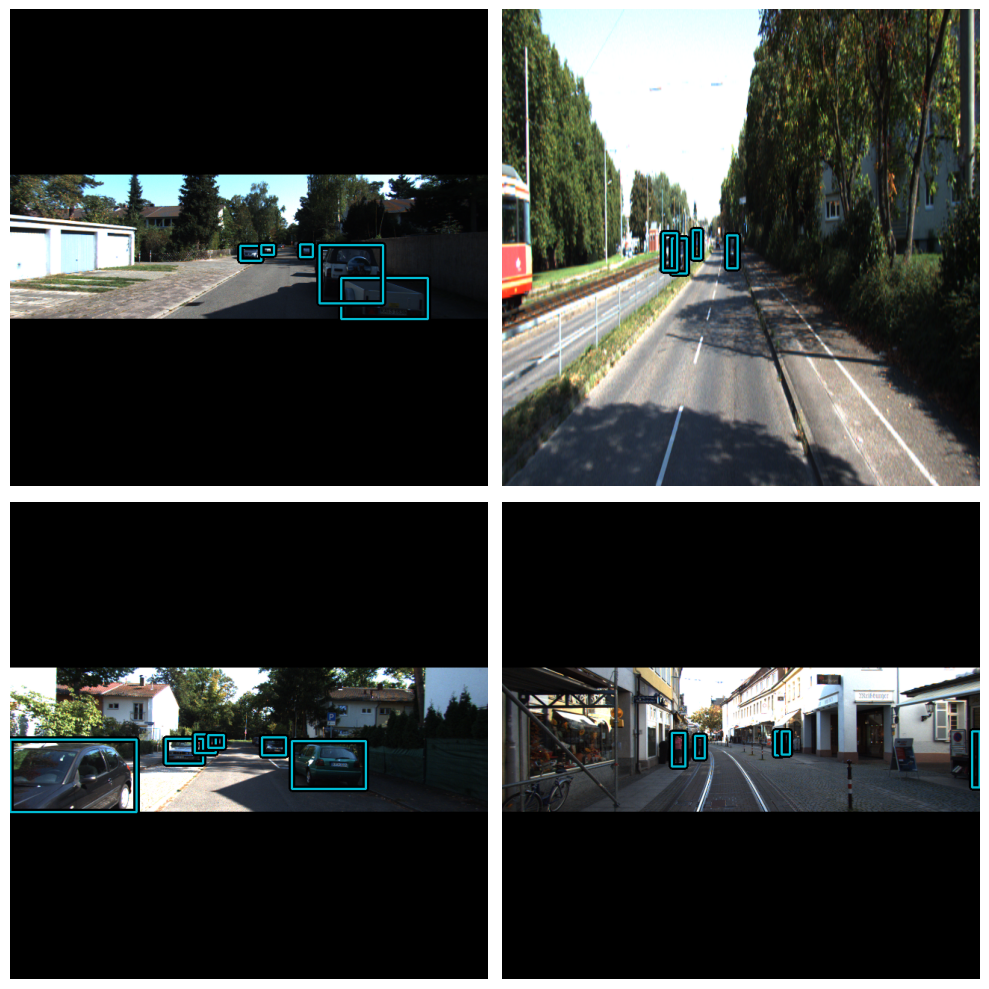

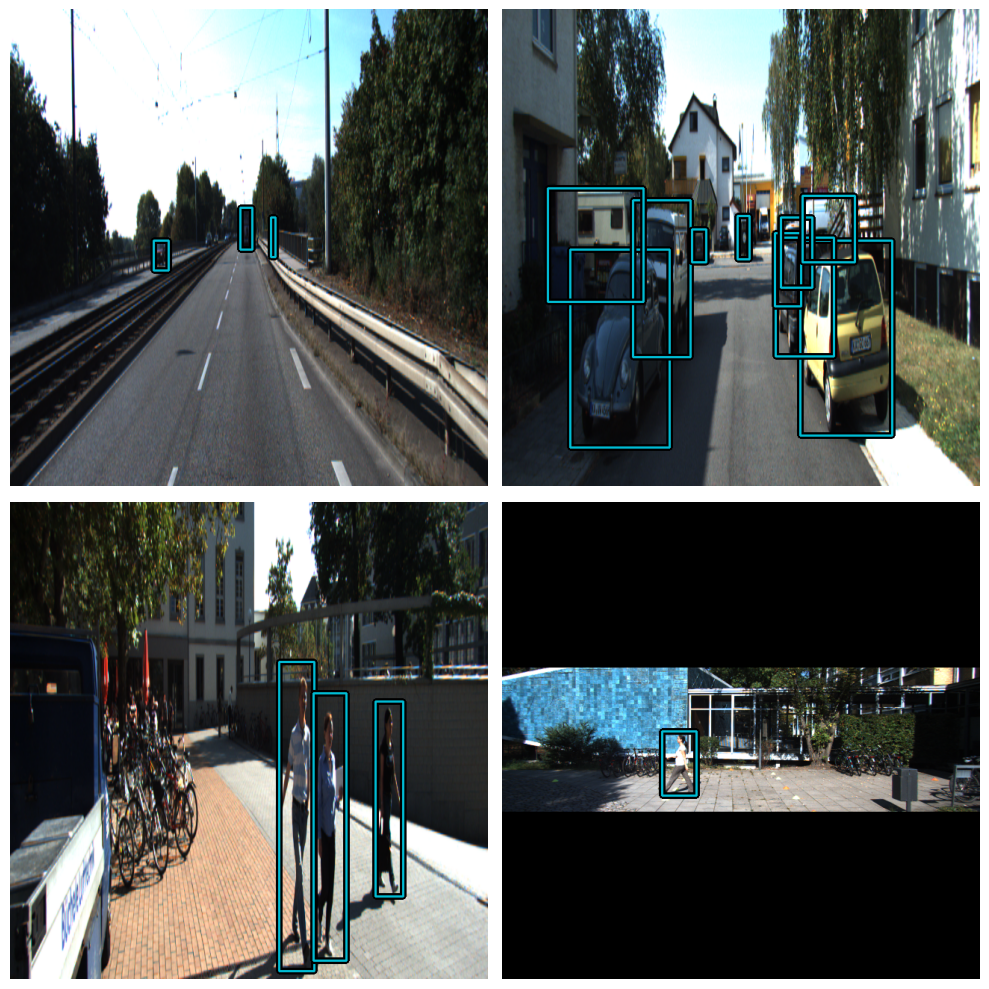

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format=BOUNDING_BOX_FORMAT, value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format=BOUNDING_BOX_FORMAT, value_range=(0, 255), rows=2, cols=2
)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
D = 0.35
W = 0.25
R = 2.0
NC = class_count

with tf.device(device.name[-5:]):
    yolo = YOLO(NC, D, W, R, iou_threshold=0.5)

yolo.compile(
    box_loss_weight=7.5,
    classification_loss_weight=0.5,
    distance_loss_weight=0.01,
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=LEARNING_RATE,
            first_decay_steps=(DECAY_EPOCHS * int(ceil((m-int(m*SPLIT_RATIO))/BATCH_SIZE))),
            alpha=1e-5,
        ),
        momentum=0.937,
        weight_decay=WEIGHT_DECAY,
        global_clipnorm=GLOBAL_CLIPNORM,
        use_ema=True,
        ema_momentum=0.9999
    )
)

In [ ]:
checkpoint = '/content/drive/MyDrive/YOLO/checkpoint'
best = '/content/drive/MyDrive/YOLO/best'

if os.path.exists(checkpoint):
    yolo.load_weights(checkpoint)

In [ ]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint,
            save_weights_only=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            best,
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            '/content/drive/MyDrive/YOLO/chkpt.weights.h5',
            save_weights_only=True,
        )
    ]
)

    498/Unknown - 425s 659ms/step - loss: 2.6746 - box_loss: 1.2863 - class_loss: 0.0144 - distance_loss: 1.3739
Epoch 1: val_loss improved from inf to 3.11219, saving model to /content/drive/MyDrive/YOLO/best
498/498 [==============================] - 517s 845ms/step - loss: 2.6746 - box_loss: 1.2863 - class_loss: 0.0144 - distance_loss: 1.3739 - val_loss: 3.1122 - val_box_loss: 1.3406 - val_class_loss: 0.0162 - val_distance_loss: 1.7554


In [ ]:
yolo.load_weights(best)

In [ ]:
yolo.evaluate(val_ds, batch_size=BATCH_SIZE)

1/1 [==============================] - 16s 16s/step


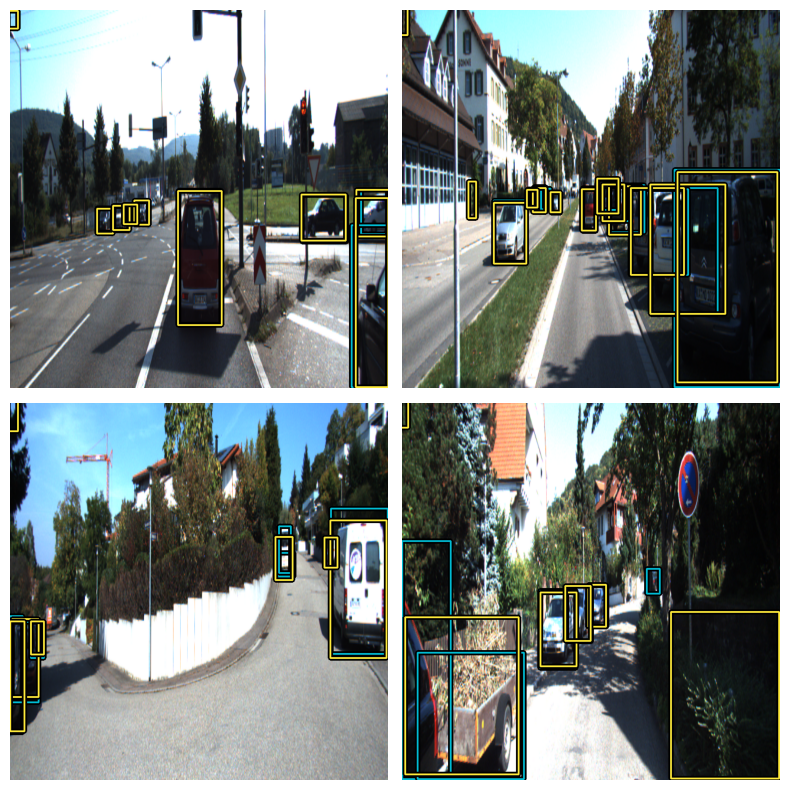

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format=BOUNDING_BOX_FORMAT)

# Quantization

In [ ]:
yolo.load_weights('/content/drive/MyDrive/YOLO/chkpt.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 1 variables whereas the saved optimizer has 415 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
for i in range(10):
    yolo.predict(np.ones((1, 640, 640, 3)))

1/1 [==============================] - 1s 1s/step


In [ ]:
def reformat(inputs):
    return inputs["images"]


ds = data.map(reformat, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def representative_data_gen():
    for input_value in ds.batch(1).take(1000):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(yolo)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


RuntimeError: Failed to quantize: <unknown>:0: error: loc("yolo/detection_head/concat"): 'tfl.concatenation' op quantization parameters violate the same scale constraint: !quant.uniform<i8:f32, 0.20071804523468018:-31> vs. !quant.uniform<i8:f32, 0.38937580585479736:-78>
<unknown>:0: note: loc("yolo/detection_head/concat"): see current operation: %346 = "tfl.concatenation"(%326, %336, %345) {axis = -1 : i32, fused_activation_function = "NONE"} : (tensor<?x80x80x64x!quant.uniform<i8:f32, 0.20071804523468018:-31>>, tensor<?x80x80x64x!quant.uniform<i8:f32, 0.20071804523468018:-31>>, tensor<?x80x80x8x!quant.uniform<i8:f32, 0.38937580585479736:-78>>) -> tensor<?x80x80x136x!quant.uniform<i8:f32, 0.20071804523468018:-31>>


In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data.shape)